<a href="https://colab.research.google.com/github/Baran-92/cyberwvu_demo/blob/main/VideoSplitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Split one uploaded video into 10 equal parts (Colab-ready) ---

# 0) Upload the video
from google.colab import files
up = files.upload()                            # pick your video file
VIDEO_PATH = next(iter(up.keys()))
print("Using:", VIDEO_PATH)

# 1) Settings
N_PARTS   = 10          # number of output clips
REENCODE  = False       # False = fastest (stream copy), True = safest (re-encode)

# 2) Utilities
import os, json, shutil, subprocess

def ffprobe_duration(path):
    # Get precise duration via ffprobe (ships with Colab)
    out = subprocess.check_output([
        "ffprobe","-v","error","-select_streams","v:0",
        "-show_entries","format=duration","-of","json", path
    ]).decode()
    return float(json.loads(out)["format"]["duration"])

# 3) Compute segment length
dur = ffprobe_duration(VIDEO_PATH)
seg = dur / N_PARTS
print(f"Duration: {dur:.3f} s  →  segment ≈ {seg:.3f} s")

# 4) Make output folder
outdir = "splits"
os.makedirs(outdir, exist_ok=True)

# 5) Split loop
for i in range(N_PARTS):
    start = i * seg
    out_f = os.path.join(outdir, f"part_{i+1:02d}.mp4")
    if i < N_PARTS - 1:
        if REENCODE:
            cmd = [
                "ffmpeg","-y","-ss", f"{start:.3f}","-i", VIDEO_PATH,
                "-t", f"{seg:.3f}",
                "-c:v","libx264","-preset","veryfast","-crf","23",
                "-c:a","aac","-b:a","128k", out_f
            ]
        else:
            cmd = [
                "ffmpeg","-y","-ss", f"{start:.3f}","-i", VIDEO_PATH,
                "-t", f"{seg:.3f}","-c","copy", out_f
            ]
    else:
        # Last part: go to end (no -t) so rounding never truncates
        if REENCODE:
            cmd = [
                "ffmpeg","-y","-ss", f"{start:.3f}","-i", VIDEO_PATH,
                "-c:v","libx264","-preset","veryfast","-crf","23",
                "-c:a","aac","-b:a","128k", out_f
            ]
        else:
            cmd = [
                "ffmpeg","-y","-ss", f"{start:.3f}","-i", VIDEO_PATH,
                "-c","copy", out_f
            ]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)

print("\nDone. Files are in ./splits/")
# 6) Optional: zip for one-click download
shutil.make_archive("splits", "zip", outdir)
files.download("splits.zip")


Saving part_06.mp4 to part_06.mp4
Using: part_06.mp4
Duration: 6.031 s  →  segment ≈ 0.603 s
Running: ffmpeg -y -ss 0.000 -i part_06.mp4 -t 0.603 -c copy splits/part_01.mp4
Running: ffmpeg -y -ss 0.603 -i part_06.mp4 -t 0.603 -c copy splits/part_02.mp4
Running: ffmpeg -y -ss 1.206 -i part_06.mp4 -t 0.603 -c copy splits/part_03.mp4
Running: ffmpeg -y -ss 1.809 -i part_06.mp4 -t 0.603 -c copy splits/part_04.mp4
Running: ffmpeg -y -ss 2.412 -i part_06.mp4 -t 0.603 -c copy splits/part_05.mp4
Running: ffmpeg -y -ss 3.015 -i part_06.mp4 -t 0.603 -c copy splits/part_06.mp4
Running: ffmpeg -y -ss 3.619 -i part_06.mp4 -t 0.603 -c copy splits/part_07.mp4
Running: ffmpeg -y -ss 4.222 -i part_06.mp4 -t 0.603 -c copy splits/part_08.mp4
Running: ffmpeg -y -ss 4.825 -i part_06.mp4 -t 0.603 -c copy splits/part_09.mp4
Running: ffmpeg -y -ss 5.428 -i part_06.mp4 -c copy splits/part_10.mp4

Done. Files are in ./splits/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Colab: system and Python deps
!apt-get -y update -qq
!apt-get -y install -qq tesseract-ocr
!pip -q install opencv-python pytesseract numpy pandas matplotlib


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Saving part_06.mp4 to part_06 (1).mp4
Using video: part_06 (1).mp4
Video info: 1872x1180 @ 24.87 fps, frames=167
Saved 75 frames to dataset/images
Preview some extracted frames? (y/n) y


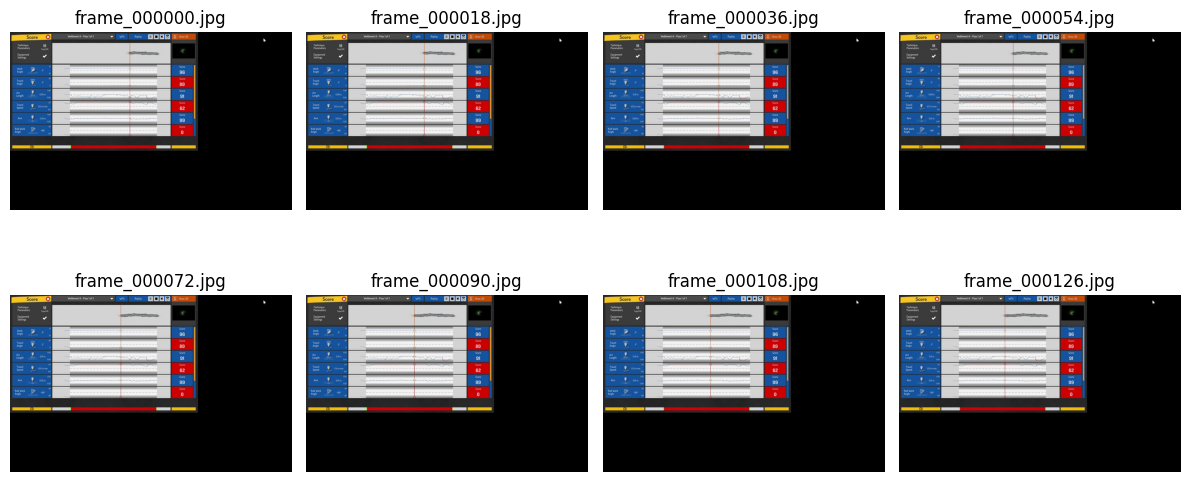

In [4]:
from google.colab import files
up = files.upload()                              # pick your weld video
VIDEO_PATH = next(iter(up.keys()))
print("Using video:", VIDEO_PATH)

# ---- Settings for frame extraction
FRAME_EVERY_N = 2   # save every Nth frame (2=half the frames; set 1 to save all)
IMG_QUALITY   = 95  # JPEG quality (1-100)

import os, cv2, math, numpy as np, matplotlib.pyplot as plt
os.makedirs("dataset/images", exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), "Could not open video."
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
N   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video info: {W}x{H} @ {fps:.2f} fps, frames={N}")

saved = []
f = 0
while True:
    ok, frame = cap.read()
    if not ok: break
    if f % FRAME_EVERY_N == 0:
        out = f"dataset/images/frame_{f:06d}.jpg"
        cv2.imwrite(out, frame, [cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY])
        saved.append((f, f/fps, out))
    f += 1
cap.release()
print(f"Saved {len(saved)} frames to dataset/images")

# Optional preview
if input("Preview some extracted frames? (y/n) ").strip().lower().startswith("y"):
    sample = saved[::max(1,len(saved)//8)][:8]  # up to 8 samples
    plt.figure(figsize=(12,6))
    for i, (_,_,p) in enumerate(sample, 1):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(2,4,i); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p))
    plt.tight_layout(); plt.show()


Cropping 75 frames...
Done. Cropped images saved in: dataset/images_cropped
Preview cropped samples? (y/n) y


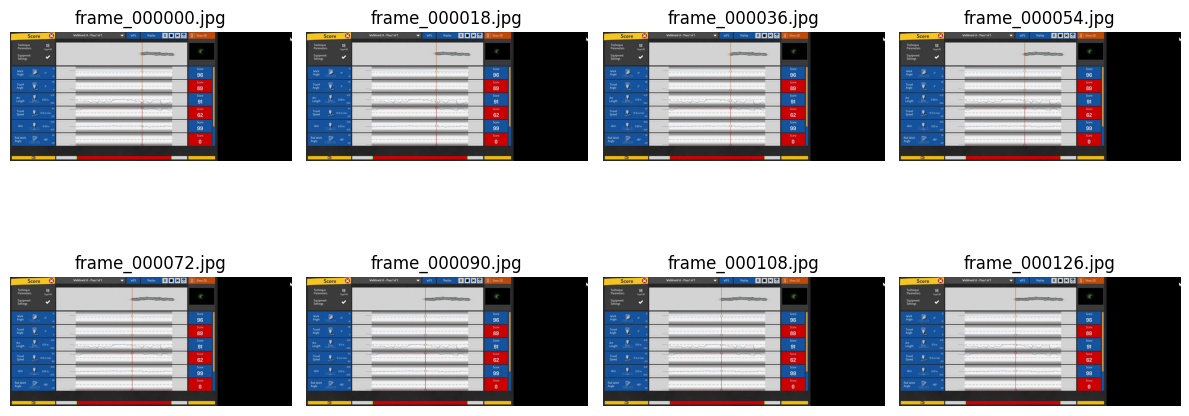

In [5]:
# === Auto-crop black background from extracted frames and preview ===
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt

IN_DIR  = "dataset/images"           # where your extracted frames are
OUT_DIR = "dataset/images_cropped"   # where we save cropped results
os.makedirs(OUT_DIR, exist_ok=True)

# Tunables (adjust if needed)
BLACK_THR  = 40     # pixels darker than this (0–255) are treated as "black"
MARGIN_PX  = 4      # keep a small margin inside the detected content
MIN_AREA   = 50000  # safety: ignore tiny detections (in pixels)

def crop_black_borders(bgr,
                       black_thr=BLACK_THR,
                       margin=MARGIN_PX,
                       min_area=MIN_AREA):
    """
    Finds the bounding box of non-black pixels and returns a tight crop.
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    mask = gray > black_thr

    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        # nothing found → return original
        h, w = bgr.shape[:2]
        return bgr, (0,0,w,h)

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    # apply small inner margin
    x1 = max(0, x1 + margin)
    y1 = max(0, y1 + margin)
    x2 = min(bgr.shape[1], x2 - margin)
    y2 = min(bgr.shape[0], y2 - margin)

    if (x2 - x1) * (y2 - y1) < min_area:
        h, w = bgr.shape[:2]
        return bgr, (0,0,w,h)

    return bgr[y1:y2, x1:x2], (x1, y1, x2 - x1, y2 - y1)

# Gather frame list (works whether you have `saved` or not)
if "saved" in globals() and isinstance(saved, list) and len(saved) > 0:
    frame_paths = [p for _,_,p in saved]
else:
    frame_paths = sorted(glob.glob(os.path.join(IN_DIR, "*.jpg")))

print(f"Cropping {len(frame_paths)} frames...")
for p in frame_paths:
    img = cv2.imread(p)
    cropped, bbox = crop_black_borders(img)
    outp = os.path.join(OUT_DIR, os.path.basename(p))
    cv2.imwrite(outp, cropped, [cv2.IMWRITE_JPEG_QUALITY, 95])

print("Done. Cropped images saved in:", OUT_DIR)

# --- Preview a few cropped images ---
if input("Preview cropped samples? (y/n) ").strip().lower().startswith("y"):
    sample = frame_paths[::max(1, len(frame_paths)//8)][:8]  # up to 8
    plt.figure(figsize=(12,6))
    for i, p in enumerate(sample, 1):
        img = cv2.cvtColor(cv2.imread(os.path.join(OUT_DIR, os.path.basename(p))), cv2.COLOR_BGR2RGB)
        plt.subplot(2,4,i); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p))
    plt.tight_layout(); plt.show()



Cropped 75 frames → dataset/images_cropped_proj
Preview cropped samples? (y/n) y


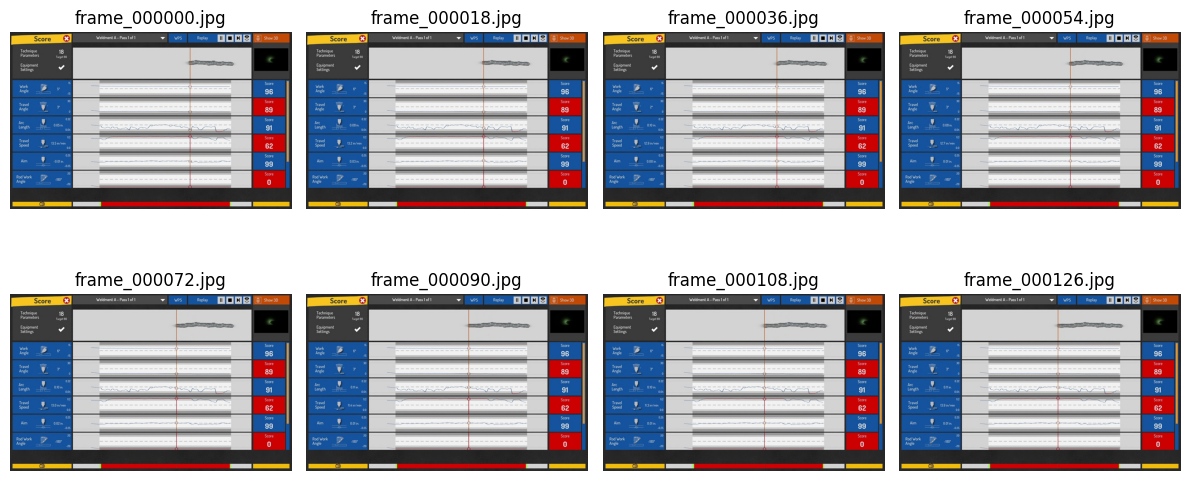

In [6]:
# === Remove left/right black bars via brightness projection (robust) ===
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt

IN_DIR  = "dataset/images"                  # your extracted frames
OUT_DIR = "dataset/images_cropped_proj"     # output folder
os.makedirs(OUT_DIR, exist_ok=True)

# Tunables
GRAY_THR_BASE   = 8      # base gray threshold (0–255); increase if bars persist (e.g., 12–20)
SMOOTH_WIN      = 15     # moving average window (pixels)
MIN_RUN_COL_PX  = 80     # minimum continuous bright columns to be considered "content"
MIN_RUN_ROW_PX  = 40     # minimum continuous bright rows
MARGIN_PX       = 4      # small inner margin after cropping

def largest_run(mask1d, min_run):
    """Return (start, end) of the longest True run with length >= min_run; else None."""
    best = (None, None, 0)
    i = 0; n = len(mask1d)
    while i < n:
        if mask1d[i]:
            j = i
            while j < n and mask1d[j]: j += 1
            length = j - i
            if length >= min_run and length > best[2]:
                best = (i, j, length)
            i = j
        else:
            i += 1
    return (best[0], best[1]) if best[0] is not None else None

def proj_crop(bgr):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Column brightness projection (mean over rows), smoothed
    col_mean = g.mean(axis=0)
    col_mean = cv2.blur(col_mean.reshape(1,-1), (1,SMOOTH_WIN)).ravel()

    # Row brightness projection (mean over cols), smoothed
    row_mean = g.mean(axis=1)
    row_mean = cv2.blur(row_mean.reshape(-1,1), (SMOOTH_WIN,1)).ravel()

    # Dynamic thresholds relative to max brightness
    col_thr = max(GRAY_THR_BASE, 0.10 * float(col_mean.max()))
    row_thr = max(GRAY_THR_BASE, 0.10 * float(row_mean.max()))

    good_cols = col_mean > col_thr
    good_rows = row_mean > row_thr

    # pick the largest continuous bright run (ignores thin bright specks at edges)
    col_run = largest_run(good_cols, MIN_RUN_COL_PX)
    row_run = largest_run(good_rows, MIN_RUN_ROW_PX)

    h, w = g.shape
    if col_run is None: col_run = (0, w)
    if row_run is None: row_run = (0, h)

    x1, x2 = col_run
    y1, y2 = row_run

    # apply small margin
    x1 = max(0, x1 + MARGIN_PX)
    y1 = max(0, y1 + MARGIN_PX)
    x2 = min(w, x2 - MARGIN_PX)
    y2 = min(h, y2 - MARGIN_PX)

    if x2 <= x1 or y2 <= y1:
        return bgr, (0,0,w,h)  # fallback

    return bgr[y1:y2, x1:x2], (x1, y1, x2-x1, y2-y1)

# --- Run on all frames
frame_paths = sorted(glob.glob(os.path.join(IN_DIR, "*.jpg")))
for p in frame_paths:
    img = cv2.imread(p)
    cropped, _ = proj_crop(img)
    cv2.imwrite(os.path.join(OUT_DIR, os.path.basename(p)), cropped, [cv2.IMWRITE_JPEG_QUALITY, 95])

print(f"Cropped {len(frame_paths)} frames → {OUT_DIR}")

# --- Preview a few results
if input("Preview cropped samples? (y/n) ").strip().lower().startswith("y"):
    sample = frame_paths[::max(1, len(frame_paths)//8)][:8]
    plt.figure(figsize=(12,6))
    for i, p in enumerate(sample, 1):
        img = cv2.cvtColor(cv2.imread(os.path.join(OUT_DIR, os.path.basename(p))), cv2.COLOR_BGR2RGB)
        plt.subplot(2,4,i); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p))
    plt.tight_layout(); plt.show()


Input frames: dataset/images_cropped_proj


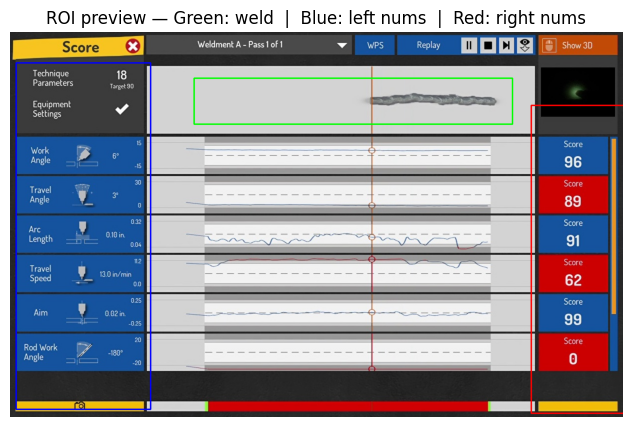

In [7]:
# --- Make 3 crops per frame: weld_top, left_nums, right_nums (Colab) ---

import os, glob, re, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Pick input dir (use the most processed one you have)
candidates = ["dataset/images_cropped_proj", "dataset/images_cropped", "dataset/images"]
for c in candidates:
    if os.path.isdir(c):
        IN_DIR = c
        break
else:
    raise SystemExit("No input folder found. Run your frame extraction step first.")

print("Input frames:", IN_DIR)

# 1) Output dirs
OUT_ROOT = "dataset"
DIR_WELD   = os.path.join(OUT_ROOT, "roi_weld_top")
DIR_LEFT   = os.path.join(OUT_ROOT, "roi_left_nums")
DIR_RIGHT  = os.path.join(OUT_ROOT, "roi_right_nums")
DIR_MERGED = os.path.join(OUT_ROOT, "roi_numbers_merged")  # only used if MERGE_LEFT_RIGHT=True
for d in [DIR_WELD, DIR_LEFT, DIR_RIGHT, DIR_MERGED]:
    os.makedirs(d, exist_ok=True)

# 2) ROI fractions (x_frac, y_frac, w_frac, h_frac) — TUNE THESE ONCE
#    Start values are calibrated to your screenshots AFTER black-trim.
ROI_WELD_F     = (0.30, 0.12, 0.52, 0.12)  # top white weld viewport
ROI_LEFTNUM_F  = (0.01, 0.08, 0.22, 0.9)  # left blue column with numbers




ROI_RIGHTNUM_F = (0.85, 0.19, 0.5, 0.8)  # right red column with numbers

# If you prefer a single "numbers" image, set this True (it will concat left|right)
MERGE_LEFT_RIGHT = False

def frac_to_px(frac, W, H):
    x,y,w,h = frac
    return int(x*W), int(y*H), int(w*W), int(h*H)

# 3) Preview ROIs on a sample frame for quick tuning
frame_paths = sorted(glob.glob(os.path.join(IN_DIR, "*.jpg")))
assert frame_paths, "No JPG frames found."

sample_path = frame_paths[len(frame_paths)//2]
img0 = cv2.imread(sample_path); H, W = img0.shape[:2]
xw,yw,ww,hw = frac_to_px(ROI_WELD_F, W, H)
xl,yl,wl,hl = frac_to_px(ROI_LEFTNUM_F, W, H)
xr,yr,wr,hr = frac_to_px(ROI_RIGHTNUM_F, W, H)

overlay = img0.copy()
cv2.rectangle(overlay, (xw,yw), (xw+ww, yw+hw), (0,255,0), 2)   # weld
cv2.rectangle(overlay, (xl,yl), (xl+wl, yl+hl), (255,0,0), 2)   # left
cv2.rectangle(overlay, (xr,yr), (xr+wr, yr+hr), (0,0,255), 2)   # right
plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("ROI preview — Green: weld  |  Blue: left nums  |  Red: right nums")
plt.axis('off'); plt.show()

# === If boxes need adjustment, edit ROI_*_F above and re-run this cell to preview again ===

# 4) Batch crop and save + build CSV index


Input frames: dataset/images_cropped_proj
Saved 75 weld-shape images to dataset/weld_shapes


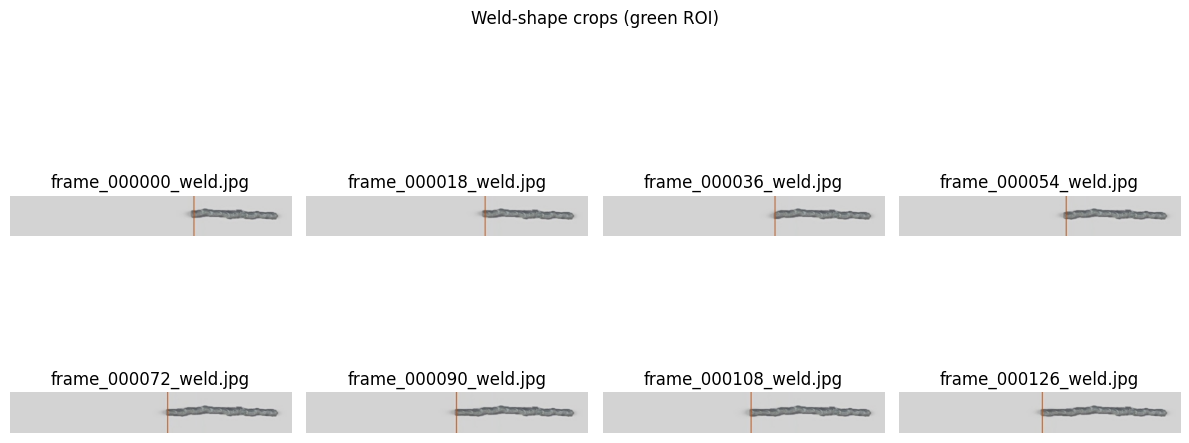

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# --- STEP 1: make weld-shape images (green ROI) from your frame sequence ---

# 0) config: where your frames live (pick the most processed one you have)
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt
candidates = ["dataset/images_cropped_proj", "dataset/images_cropped", "dataset/images"]
for c in candidates:
    if os.path.isdir(c) and len(glob.glob(os.path.join(c, "*.jpg")))>0:
        IN_DIR = c
        break
else:
    raise SystemExit("No JPG frames found. Set IN_DIR to your frames folder.")

print("Input frames:", IN_DIR)

# 1) your tuned ROIs (keep your existing values; these are fallbacks)
try:
    ROI_WELD_F
except NameError:
    ROI_WELD_F     = (0.20, 0.06, 0.66, 0.12)   # (x,y,w,h) as fractions

def frac_to_px(frac, W, H):
    x,y,w,h = frac
    return int(x*W), int(y*H), int(w*W), int(h*H)

# 2) crop & save
OUT_WELD_DIR = "dataset/weld_shapes"
os.makedirs(OUT_WELD_DIR, exist_ok=True)

frame_paths = sorted(glob.glob(os.path.join(IN_DIR, "*.jpg")))
weld_paths = []
for p in frame_paths:
    img = cv2.imread(p); H, W = img.shape[:2]
    x,y,w,h = frac_to_px(ROI_WELD_F, W, H)
    crop = img[y:y+h, x:x+w]
    outp = os.path.join(OUT_WELD_DIR, os.path.splitext(os.path.basename(p))[0] + "_weld.jpg")
    cv2.imwrite(outp, crop, [cv2.IMWRITE_JPEG_QUALITY, 95])
    weld_paths.append(outp)

print(f"Saved {len(weld_paths)} weld-shape images to {OUT_WELD_DIR}")

# 3) preview a few weld crops
plt.figure(figsize=(12,6))
sample = weld_paths[::max(1, len(weld_paths)//8)][:8]
for i, p in enumerate(sample, 1):
    im = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i); plt.imshow(im); plt.axis('off'); plt.title(os.path.basename(p))
plt.suptitle("Weld-shape crops (green ROI)"); plt.tight_layout(); plt.show()

# 4) save as a zip for download
import shutil
weld_zip = "weld_shapes.zip"
shutil.make_archive("weld_shapes", "zip", OUT_WELD_DIR)
from google.colab import files
files.download(weld_zip)


Up to this point everything works well. I could collect images for the database.
Now I need to capture parameters' change.

In [12]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xlsxwriter"])

from pandas import ExcelWriter
# now this works:
with pd.ExcelWriter("parameters_timeseries.xlsx", engine="xlsxwriter") as wr:
    df.to_excel(wr, index=False, sheet_name="params")


In [18]:
!pip -q install easyocr
import easyocr
reader = easyocr.Reader(['en'], gpu=False)
# val = float(re.findall(r'-?\d+(?:\.\d+)?', ' '.join(reader.readtext(img, detail=0)) )[0])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 17.8 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [20]:
# ==== HYBRID OCR: capture parameters (Tesseract first, EasyOCR fallback) ====
import os, glob, re, cv2, numpy as np, pandas as pd, pytesseract, matplotlib.pyplot as plt

# If EasyOCR reader not created yet:
try:
    reader
except NameError:
    import easyocr
    reader = easyocr.Reader(['en'], gpu=False)

# ------ locate frames if not already present ------
def list_imgs(d):
    out = []
    for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
        out += glob.glob(os.path.join(d, ext))
    return sorted(out)

if 'frame_paths' not in globals() or not frame_paths:
    for cand in ["dataset/images_cropped_proj","dataset/images_cropped","dataset/images","frames"]:
        if os.path.isdir(cand):
            imgs = list_imgs(cand)
            if imgs:
                frame_paths = imgs
                break
    assert frame_paths, "No frame images found; run your extraction step first."

print(f"Using {len(frame_paths)} frames from: {os.path.dirname(frame_paths[0])}")

# ------ your ROIs (already tuned) ------
try:
    ROI_LEFTNUM_F
except NameError:
    ROI_LEFTNUM_F  = (0.015, 0.110, 0.265, 0.75)  # BLUE left panel
try:
    ROI_RIGHTNUM_F
except NameError:
    ROI_RIGHTNUM_F = (0.87, 0.19, 0.11, 0.68)     # RED right panel

# ------ panel structure ------
LEFT_ROWS  = 6
RIGHT_ROWS = 6
PARAM_NAMES = ["Work_Angle","Travel_Angle","CTWD","Travel_Speed","Aim","Rod_Work_Angle"]  # left/top→bottom
assert len(PARAM_NAMES) == LEFT_ROWS

# inside-row slices (fractions of the row patch)
LEFT_X_SLICE,  LEFT_Y_SLICE  = (0.60, 0.98), (0.25, 0.80)   # focus on where digits are
RIGHT_X_SLICE, RIGHT_Y_SLICE = (0.45, 0.95), (0.20, 0.80)

# ------ OCR configs & helpers ------
OCR_NUM = (
    r'--psm 7 --oem 1 '
    r'-c tessedit_char_whitelist=0123456789.- '
    r'-c classify_bln_numeric_mode=1 '
    r'-c user_defined_dpi=150'
)
NUM_RE   = re.compile(r'(-?\d+(?:\.\d+)?)')
FRAME_RE = re.compile(r'(\d+)')

def frac_to_px(frac, W, H):
    x,y,w,h = frac
    return int(x*W), int(y*H), int(w*W), int(h*H)

def crop_frac(img, x0_frac, x1_frac, y0_frac, y1_frac):
    H, W = img.shape[:2]
    x0, x1 = int(W*x0_frac), int(W*x1_frac)
    y0, y1 = int(H*y0_frac), int(H*y1_frac)
    x0 = max(0, min(W-1, x0)); x1 = max(1, min(W, x1))
    y0 = max(0, min(H-1, y0)); y1 = max(1, min(H, y1))
    if x1 <= x0 or y1 <= y0: return img
    return img[y0:y1, x0:x1]

def preprocess_for_tess(bgr):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)); g = clahe.apply(g)
    g = cv2.GaussianBlur(g, (3,3), 0)
    _, binimg = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if binimg.mean() < 127: binimg = 255 - binimg
    h = 64
    binimg = cv2.resize(binimg, (int(binimg.shape[1]*h/binimg.shape[0]), h), interpolation=cv2.INTER_LINEAR)
    binimg = cv2.medianBlur(binimg, 3)
    return binimg

def ocr_tesseract_number(img_bin):
    s = pytesseract.image_to_string(img_bin, config=OCR_NUM)
    m = NUM_RE.search(s)
    return (float(m.group(1)) if m else None)

def ocr_easyocr_number(img_bgr):
    results = reader.readtext(img_bgr, detail=1)  # list of (bbox, text, conf)
    best = None
    for _, txt, conf in results:
        for m in NUM_RE.finditer(txt):
            val = float(m.group(1))
            if best is None or conf > best[1]:
                best = (val, conf)
    return (best[0] if best else None)

def ocr_numeric_hybrid(row_patch, x_slice, y_slice):
    roi = crop_frac(row_patch, x_slice[0], x_slice[1], y_slice[0], y_slice[1])
    # try tess first
    v = ocr_tesseract_number(preprocess_for_tess(roi))
    if v is not None:
        return v
    # fallback to easyocr on color patch
    return ocr_easyocr_number(roi)

# ------ run over frames ------
rows = []
WELD_DIR = "dataset/weld_shapes"

for p in frame_paths:
    img = cv2.imread(p); H, W = img.shape[:2]
    # crop the two panels
    xl,yl,wl,hl = frac_to_px(ROI_LEFTNUM_F,  W, H)
    xr,yr,wr,hr = frac_to_px(ROI_RIGHTNUM_F, W, H)
    left  = img[yl:yl+hl, xl:xl+wl]
    right = img[yr:yr+hr, xr:xr+wr]

    # left rows
    lh, lw = left.shape[:2]; l_row_h = lh // LEFT_ROWS
    left_vals = []
    for r in range(LEFT_ROWS):
        y0 = r * l_row_h
        y1 = lh if r == LEFT_ROWS-1 else (r+1) * l_row_h
        row_patch = left[y0:y1, :]
        left_vals.append(ocr_numeric_hybrid(row_patch, LEFT_X_SLICE, LEFT_Y_SLICE))

    # right rows
    rh, rw = right.shape[:2]; r_row_h = rh // RIGHT_ROWS
    right_vals = []
    for r in range(RIGHT_ROWS):
        y0 = r * r_row_h
        y1 = rh if r == RIGHT_ROWS-1 else (r+1) * r_row_h
        row_patch = right[y0:y1, :]
        right_vals.append(ocr_numeric_hybrid(row_patch, RIGHT_X_SLICE, RIGHT_Y_SLICE))

    base = os.path.basename(p)
    m = FRAME_RE.search(base); frame_idx = int(m.group(1)) if m else None
    weld_img = os.path.join(WELD_DIR, os.path.splitext(base)[0] + "_weld.jpg")
    if not os.path.isfile(weld_img): weld_img = ""

    rec = {"frame": frame_idx, "frame_image": p, "weld_image": weld_img}
    for name, v in zip(PARAM_NAMES, left_vals): rec[name] = v
    for i, v in enumerate(right_vals, 1):       rec[f"Right_{i}"] = v
    rows.append(rec)

df = pd.DataFrame(rows).sort_values("frame").reset_index(drop=True)

# Optional: light temporal smoothing for stability (rolling median)
num_cols = [c for c in df.columns if c not in ("frame","frame_image","weld_image")]
df[num_cols] = df[num_cols].rolling(window=5, center=True, min_periods=1).median()

print("Preview (first 10 rows):")
display(df.head(10))


Using 75 frames from: dataset/images_cropped_proj


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

Preview (first 10 rows):


,frame,frame_image,weld_image,Work_Angle,Travel_Angle,CTWD,Travel_Speed,Aim,Rod_Work_Angle,Right_1,Right_2,Right_3,Right_4,Right_5,Right_6
0,0,dataset/images_cropped_proj/frame_000000.jpg,dataset/weld_shapes/frame_000000_weld.jpg,90.0,NaN,NaN,13.50,25.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
1,2,dataset/images_cropped_proj/frame_000002.jpg,dataset/weld_shapes/frame_000002_weld.jpg,90.0,NaN,NaN,13.45,16.5,NaN,NaN,2.0,11.0,2.0,NaN,NaN
2,4,dataset/images_cropped_proj/frame_000004.jpg,dataset/weld_shapes/frame_000004_weld.jpg,90.0,NaN,NaN,13.40,8.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
3,6,dataset/images_cropped_proj/frame_000006.jpg,dataset/weld_shapes/frame_000006_weld.jpg,90.0,NaN,NaN,2.00,8.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
4,8,dataset/images_cropped_proj/frame_000008.jpg,dataset/weld_shapes/frame_000008_weld.jpg,90.0,NaN,NaN,2.00,0.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
5,10,dataset/images_cropped_proj/frame_000010.jpg,dataset/weld_shapes/frame_000010_weld.jpg,90.0,NaN,NaN,2.00,8.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
6,12,dataset/images_cropped_proj/frame_000012.jpg,dataset/weld_shapes/frame_000012_weld.jpg,90.0,NaN,NaN,2.00,0.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
7,14,dataset/images_cropped_proj/frame_000014.jpg,dataset/weld_shapes/frame_000014_weld.jpg,90.0,NaN,NaN,2.00,8.8,NaN,NaN,2.0,11.0,2.0,NaN,NaN
8,16,dataset/images_cropped_proj/frame_000016.jpg,dataset/weld_shapes/frame_000016_weld.jpg,90.0,NaN,NaN,13.20,0.0,NaN,NaN,2.0,11.0,2.0,NaN,NaN
9,18,dataset/images_cropped_proj/frame_000018.jpg,dataset/weld_shapes/frame_000018_weld.jpg,90.0,NaN,NaN,2.00,8.8,NaN,NaN,2.0,11.0,2.0,NaN,NaN


In [ ]:
# Save as CSV + Excel and download
import sys, subprocess, pandas as pd
from google.colab import files

df.to_csv("parameters_hybrid.csv", index=False)
try:
    import xlsxwriter  # noqa
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xlsxwriter"])
with pd.ExcelWriter("parameters_hybrid.xlsx", engine="xlsxwriter") as wr:
    df.to_excel(wr, index=False, sheet_name="params")

files.download("parameters_hybrid.csv")
files.download("parameters_hybrid.xlsx")
